In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def value(x_true, y_true, x_sensor, y_sensor):
    return 1 / (0.1 + (x_true - x_sensor)**2 + (y_true - y_sensor)**2)

# Read observed values from file
with open("EarthquakeExerciseData.txt") as f:
    lines = f.readlines()
v_observed = [float(line.strip()) for line in lines]

num_explosions = 2

# Define the coordinate system:
S = 2000  # number of points on the spiral
theta = 55 * 2 * np.pi * np.arange(S) / S
r = np.arange(S) / S
x = r * np.cos(theta)
y = r * np.sin(theta)

# Define the locations of the detection stations on the surface
N = len(v_observed)  # number of stations (will be overwritten by file length)
theta_sensor = 2 * np.pi * np.arange(N) / N
x_sensor = np.cos(theta_sensor)
y_sensor = np.sin(theta_sensor)

# Calculate the explosion values for the sensors
v = np.zeros((S, N))
for sensor in range(N):
    for s in range(S):
        v[s, sensor] = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor])

# Perform inference p(location|observed sensor values) given these sensor values
max_prob = 0
logp1 = np.zeros(S)
logp2 = np.zeros(S)
for s in range(S):
    loc_prob = 0
    for s2 in range(S):
        #if s == s2:
        #    continue
        combined = 0
        for sensor in range(N):
            calc1 = value(x[s], y[s], x_sensor[sensor], y_sensor[sensor])
            calc2 = value(x[s2], y[s2], x_sensor[sensor], y_sensor[sensor])
            combined += -0.5 * (v_observed[sensor] - (calc1+calc2))**2
        combined = np.exp(combined)
        if combined > loc_prob:
            loc_prob = combined
            logp1[s] = loc_prob
            logp2[s2] = loc_prob
        if combined > max_prob:
            max_prob = combined
            max_idx = (s, s2)

logp = logp1 + logp2

p = logp - np.max(logp)  # do exponentiation (and avoid over/underflow)
p /= np.sum(p)  # normalize

# Plot the posterior and most likely location of the explosion:
maxp = np.max(p)
print((x[max_idx[0]], y[max_idx[0]]))
print(p[max_idx[0]])
print((x[max_idx[1]], y[max_idx[1]]))
print(p[max_idx[1]])


(0.2743433190292394, 0.4322958978570361)
-0.0
(-0.842216165553134, 0.18825761732523844)
2.6222664796810748e-05


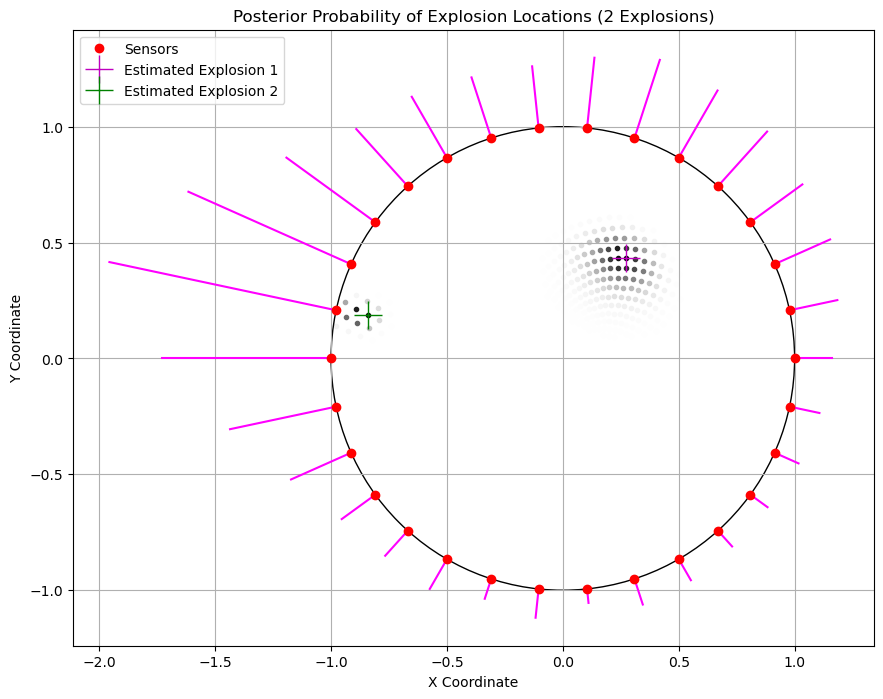

In [29]:
fig = plt.figure(figsize=(11,8))
ax = fig.subplots()

# Plot sensor locations
for s in range(S):
    ax.plot(x[s], y[s], ".", color=((p[s] / maxp)) * np.ones(3), zorder=0)

# Draw circle formed by sensors
sensors_circle = plt.Circle((0,0),1, fill=False)
ax.add_artist(sensors_circle)

for sensor in range(N):
# Normalize the line length to the observed data
    line_length = v_observed[sensor] / np.max(v_observed)
    ax.plot([x_sensor[sensor], x_sensor[sensor] * (1 + line_length)],
            [y_sensor[sensor], y_sensor[sensor] * (1 + line_length)],
            color='magenta')

ax.plot(x_sensor, y_sensor, "ro", label="Sensors")
ax.plot(x[max_idx[0]], y[max_idx[0]], "m+", markersize=20, label="Estimated Explosion 1")
ax.plot(x[max_idx[1]], y[max_idx[1]], "g+", markersize=20, label="Estimated Explosion 2")
ax.legend()
ax.set_title('Posterior Probability of Explosion Locations (2 Explosions)')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_aspect(1)
ax.grid()
plt.show()